In [1]:
%run init_notebook.py

In [2]:
import pandas as pd
import numpy as np

import os
import datetime as dt
from functools import wraps

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from settings import RAW_DATA_DIR, WORK_DATA_DIR, OUT_DATA_DIR, OUT_MODEL_DIR, random_state
from utils.utils import *
from utils.load import load_data, save_file, save_model
from utils.cast_data import apply_datetime_format, apply_date_to_week
from utils.plotting import *
from src.src import *

In [4]:
# Load data
model_type = "ols"
data_len = 1560 # 440, 660, 760, 1560, 8055
is_sent = True
week_day = 'weekly'
predicted = "sp_close_lead1"

year_start = 2019
year_end = 2021
year_spread = f'years{year_end}_{year_start}'

df_w = load_data(file_name=f"df_{week_day}_{data_len}.csv", file_path=WORK_DATA_DIR)
data_dict = load_data(file_name=f"dict_{week_day}_{data_len}.pkl", file_path=WORK_DATA_DIR)

Unknown columns found, columns were not casted
['weekday_0.1', 'weekday_1.1', 'weekday_2.1', 'weekday_3.1', 'weekday_4.1']
Exceptions were found
[KeyError('weekday_0.1'), KeyError('weekday_1.1'), KeyError('weekday_2.1'), KeyError('weekday_3.1'), KeyError('weekday_4.1')]


In [5]:
if week_day == 'daily':
    assert is_sent is False, 'Treating non sentiment data'
    # training on X years
    df_w = df_w[(df_w["date"] >= dt.datetime(year=year_start, month=1, day=1).date())
             &(df_w["date"] <= dt.datetime(year=year_end, month=12, day=31).date())]
    print(f'data compromises {year_end - year_start} years: {df_w.shape[0]} lines')
else:
    year_spread = 'yearsNA'
    df_w = cut_to_weekly_data(df_w, 'is_thu')

In [6]:
# update dict with model specific information
data_dict["model_features"].update(predicted=predicted)
data_dict["model_features"].update(datetime_ind=dict(zip(df_w.index, df_w.date)))

data_dict["model_metrics"].update(model_type=model_type)
data_dict["model_metrics"].update(data_len=data_len)
data_dict["model_metrics"].update(is_sent=is_sent)
data_dict["model_metrics"].update(week_day=week_day)
data_dict["model_metrics"].update(year_spread=year_spread)
data_dict["model_metrics"].update(model_name=f"{model_type}_{data_len}_{year_spread}_{data_dict['model_features']['predicted']}_sent{is_sent}")

# data selection

In [32]:
# select model features
cols = [item for item in data_dict["data"]["relevant_cols"] if "lead" not in item]
cols = [
    'vixo',
     # 'naaim_ind',
     # 'naaim_max',
     # 'naaim_q1',
     'ff_M_RF',
     'ff_SMB',
     'ff_HML',
     'ff_RMW',
     'ff_CMA',
     'termspread',
     # 'pc_ratio',
     # 'fears35',
     'aaii_Bullish',
     'aaii_Bearish',
     'aaii_Neutral',
     'sp_close',
     'sp_close_lag1',
     'sp_close_lag2',
     # 'sp_close_lag3',
     # 'sp_close_lag4',
     # 'sp_close_lag5',
     # 'sp_close_lag6',
     # 'sp_close_lag7',
     # 'sp_close_lag8',
     # 'sp_close_lag9',
     # 'sp_close_lag10'
]

categorical = [    
     # 'weekday',
     # 'weekday_0',
     # 'weekday_1',
     # 'weekday_2',
     # 'weekday_3',
     # 'weekday_4'
]

## categorical features
if len(categorical) > 0:
    cols = cols + categorical
    data_dict["model_features"]["categorical"] = categorical

# predictors are all X cols
data_dict["model_features"].update(predictor=[item for item in cols if item != data_dict["model_features"]["predicted"]])

# TTS

In [33]:
df_train = df_w[cols + [data_dict["model_features"]["predicted"]]].copy()

In [34]:
X_train, X_test, y_train, y_test = tts_data(df_train,
                                            y=data_dict["model_features"]["predicted"],
                                            x=cols,
                                            random_split=False,
                                            test_size=.3,
                                            add_const=False)

# Sesonality

In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [36]:
## SEASONALITY DF
# create sub dataframe of X_train
X_train_sea = X_train.copy()

# insert datetime information
X_train_sea["date"] = pd.Series(X_train_sea.index).apply(lambda x: data_dict["model_features"]["datetime_ind"][x]).values
X_train_sea["weekday"] = is_day(X_train_sea.date)
X_train_sea["week"] = X_train_sea.date.apply(lambda x: apply_date_to_week(x))

# filter for complete weeks only
_ = X_train_sea.groupby("week").weekday.count() == 5
_ = _[_].index
X_train_sea = X_train_sea[X_train_sea["week"].isin(_)]

In [49]:
## SEASONALITY ANALYSIS
if week_day == "daily":
    # create statsmodel seasonality object
    sd = seasonal_decompose(X_train_sea.sp_close, period=5)
    sd.plot()
    plt.show()

    # get seasonality by weekday
    X_train_sea["seasonal"] = sd.seasonal
    data_dict["model_features"].update(weekday_seasonality= dict(zip(X_train_sea.groupby("weekday").seasonal.first().index, X_train_sea.groupby("weekday").seasonal.first().values)))

    # map sesonality to data
    _ = pd.Series(X_test.index).apply(lambda x: data_dict["model_features"]["datetime_ind"][x])
    X_test["seasonal"] = is_day(_).map(data_dict["model_features"]["weekday_seasonality"]).values

    _ = pd.Series(X_train.index).apply(lambda x: data_dict["model_features"]["datetime_ind"][x])
    X_train["seasonal"] = is_day(_).map(data_dict["model_features"]["weekday_seasonality"]).values

    cols.append("seasonal")

# Corr

In [50]:
# merging X, y for analysis purposes
X_train = pd.concat([X_train, y_train], axis=1)

Lag corr

In [51]:
df_cross_corr(X_train,
              [item for item in cols if item not in data_dict["data"]["sp_cols"]],
              data_dict["model_features"]["predicted"],
              show_plot=False,
              no_lags=20,
              figsize=(6, 3))

[['vixo', 6, 0.067],
 ['ff_M_RF', 19, 0.077],
 ['ff_SMB', 12, 0.062],
 ['ff_HML', 6, 0.086],
 ['ff_RMW', 4, 0.079],
 ['ff_CMA', 2, 0.071],
 ['termspread', 0, 0.043],
 ['aaii_Bullish', 6, 0.082],
 ['aaii_Bearish', 8, 0.068],
 ['aaii_Neutral', 2, 0.073]]

In [52]:
# X_train, _ = shift_var_relative_to_df(X_train,
#                                       shift_var=['ff_M_RF',
#                                                  'ff_SMB',
#                                                  'ff_HML',
#                                                  'ff_RMW',
#                                                  'ff_CMA'],
#                                       no_lags=[6, 4, 1, 6, 2])

# X_test, _ = shift_var_relative_to_df(X_test,
#                                       shift_var=['ff_M_RF',
#                                                  'ff_SMB',
#                                                  'ff_HML',
#                                                  'ff_RMW',
#                                                  'ff_CMA'],
#                                       no_lags=[6, 4, 1, 6, 2])

# data_dict["data_transformation"].update(shift_var=_)
# X_train = X_train.dropna()
# X_test = X_test.dropna()

Corr matrix

In [53]:
## ORTHOGONALISE
X_train = orthogonalise_vars(X_train, X="sp_close", y="ff_M_RF", show_fig=False)
X_train = orthogonalise_vars(X_train, X="ff_SMB", y="ff_M_RF", show_fig=False)

,VIF,corr_sp_close_lead1
ff_RMW,1.496291,-0.019498
sp_close,1.273675,-0.013855
aaii_Bullish,20.098779,-0.013482
sp_close_lag1,1.074977,-0.009257
ff_CMA,1.695365,0.003463
aaii_Bearish,14.767848,0.003782
ff_SMB,1.120062,0.007134
aaii_Neutral,22.566307,0.011400
ff_M_RF,1.575735,0.035609
ff_HML,1.452693,0.038150


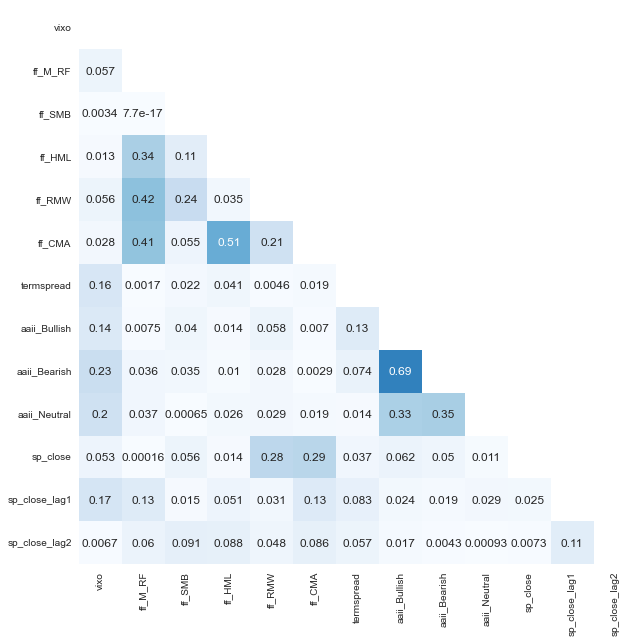

In [54]:
# only rely on correlation not vif
corr_heatmap(X_train, 
             cols,
             # size_factor=1,
             show_fig=True)

get_variance_inflation_factor(
                              X_train,
                              # pd.concat([X_test, y_test], axis=1),
                              cols,
                              col_pred=data_dict["model_features"]["predicted"])

# Model

In [55]:
# dropping y col from X_train
X_train.drop(data_dict["model_features"]['predicted'], axis=1, inplace=True)
y_train = y_train.loc[X_train.index]
y_test = y_test.loc[X_test.index]

In [56]:
model = SKLearnWrap(sm.OLS, fit_intercept=True)
model_ = model.fit(X_train, y_train)

In [57]:
data_dict["model_metrics"].update(featuer_sig=model.results_.pvalues)
model.results_.pvalues < .05

vixo             False
ff_M_RF          False
ff_SMB           False
ff_HML           False
ff_RMW           False
ff_CMA           False
termspread       False
aaii_Bullish     False
aaii_Bearish     False
aaii_Neutral     False
sp_close         False
sp_close_lag1    False
sp_close_lag2     True
intercept        False
dtype: bool

In [58]:
model.results_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         sp_close_lead1   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.359
Date:                Mon, 21 Mar 2022   Prob (F-statistic):              0.173
Time:                        17:05:02   Log-Likelihood:                 3490.6
No. Observations:                1113   AIC:                            -6953.
Df Residuals:                    1099   BIC:                            -6883.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
vixo              0.0014      0.001      1.417      0.157      -0.001       0.003
ff_M_RF           0.0049      0.004      1.356      0.175      -0.002       0.012
ff_SMB           -0.0002      0.001     -0.269      0.788      -0.001       0.001
ff_HML            0.0010      0.001      1.666      0.096      -0.000       0.002
ff_RMW        -4.345e-05      0.001     -0.056      0.956      -0.002       0.001
ff_CMA           -0.0004      0.001     -0.447      0.655      -0.002       0.001
termspread        0.0017      0.002      1.089      0.276      -0.001       0.005
aaii_Bullish      0.0002      0.003      0.062      0.951      -0.006       0.006
aaii_Bearish  -2.432e-05      0.002     -0.010      0.992      -0.005       0.005
aaii_Neutral      0.0009      0.002      0.420      0.675      -0.003       0.005
sp_close         -0.0147      0.030     -0.490      0.624      -0.074       0.044
sp_close_lag1     0.0043      0.029      0.146      0.884      -0.053       0.062
sp_close_lag2     0.0749      0.026      2.856      0.004       0.023       0.126
intercept        -0.0048      0.008     -0.587      0.558      -0.021       0.011
==============================================================================
Omnibus:                      100.374   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              407.378
Skew:                          -0.333   Prob(JB):                     3.46e-89
Kurtosis:                       5.888   Cond. No.                         376.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Out of sample eval

In [59]:
# benchmark: mittelwert prognose - das ist ein random walk mit drift

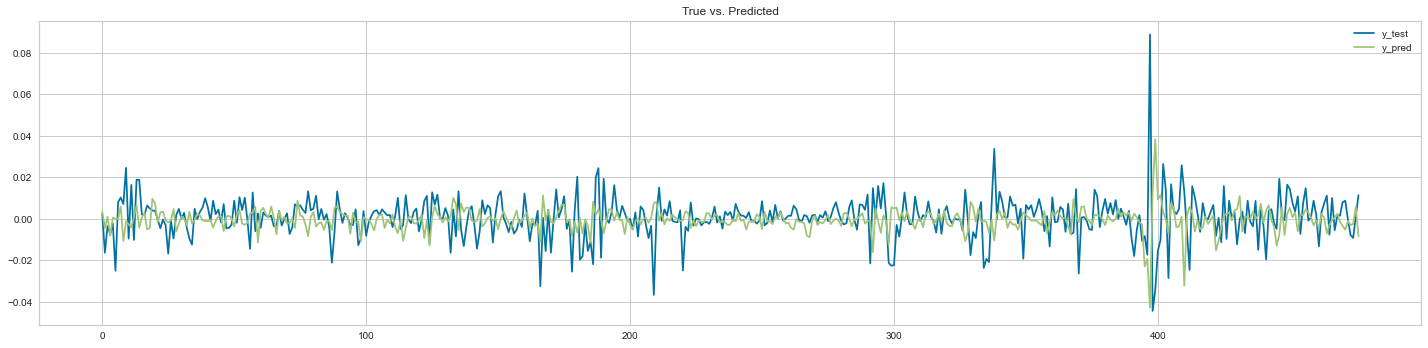

Validation Scores
root mean squared error: 0.0126236256
mean squared error: 0.0001593559
mean absolute error: 0.0080099442
R2: -0.5108850189


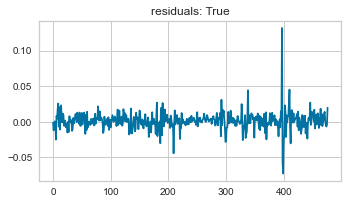

Stationarity Test Results
P-Values: 2.21405102964761e-29
Test-stats: -16.486143748225484
Time series is stationary: True


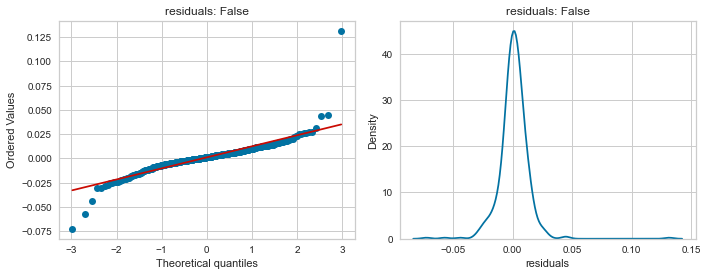

Normality Test Results
P-Values: 7.815873408785679e-59
Test-stats: 267.5927275369176
Series is normally distributed: False
HET WHITE TEST REQUIRES A CONSTANT IN X DATA
adding constant to data


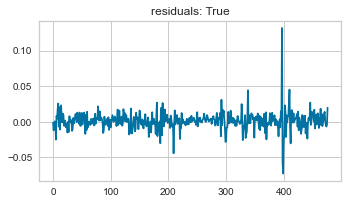

Test for Heteroskedasticity
Test p-value: 2.4190900126363034e-46
Heteroskedasticity is present: True


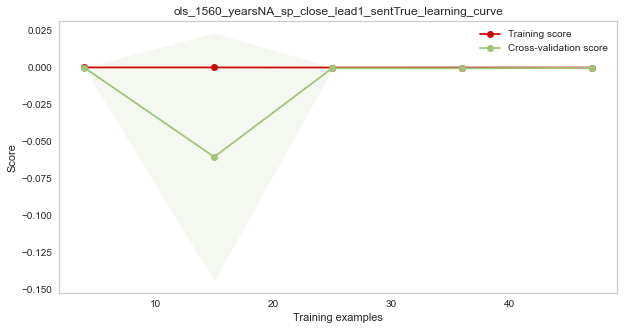

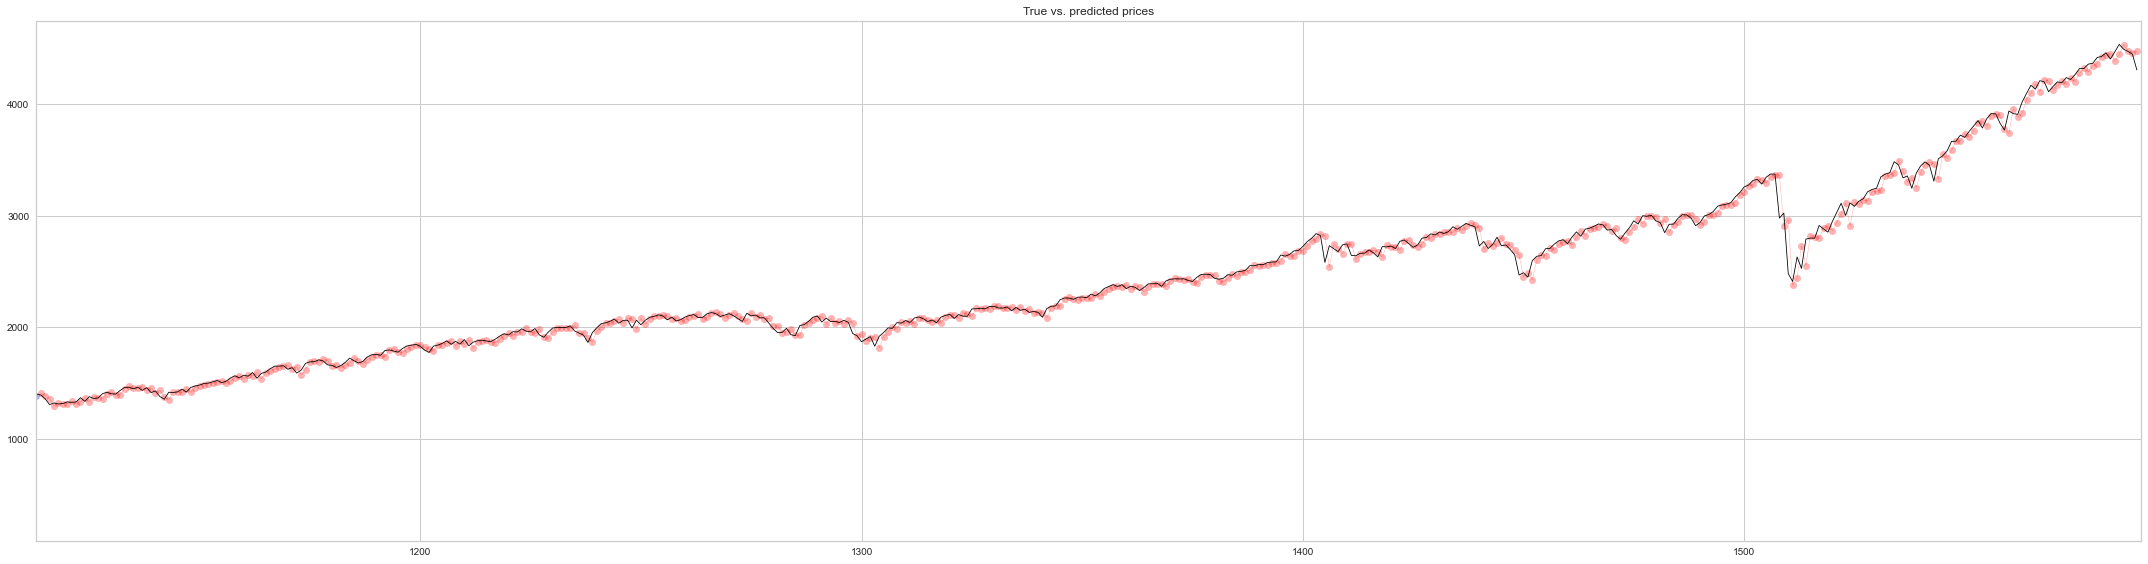

Validation Scores Test Data
mean squared error: 3298.9349074446
mean absolute error: 36.0895542132
mean absolute error in %: 0.025700127393056906
r2: 0.9941205976


In [60]:
mval = ModelValidation(
            X_train=X_train,
            y_train=y_train,
            X_validate=X_test,
            y_validate=y_test,
            model=model,
            print_results=True)

fig_true_vs_fit = mval.get_model_performance()
stat, norm, hetero = mval.analyse_resids()

fig_lcurve = mval.sm_learning_curve(f"{data_dict['model_metrics']['model_name']}_learning_curve", n_splits=10)
fig_prices = mval.plot_results_on_price_scale(df_w,
                                              df_train,
                                              sp_true_vals=data_dict["data"]["sp_true_vals"], show_pred_only=True)

# update dict
# residuals
data_dict["model_metrics"].update(resid_stationarity=stat)
data_dict["model_metrics"].update(resid_normality=norm)
data_dict["model_metrics"].update(resid_heterskedasticity=hetero)

# model performance
data_dict["model_metrics"].update(rmse=mval.rmse)
data_dict["model_metrics"].update(mse=mval.mse)
data_dict["model_metrics"].update(mae=mval.mae)
data_dict["model_metrics"].update(r2=mval.r2)
data_dict["model_metrics"].update(residuals=mval.resid_inv)

# Save model

In [61]:
save_model(model, df_train, data_dict, fig_true_vs_fit, fig_lcurve, fig_prices, OUT_MODEL_DIR)

Are you sure you want to save model as: f"2022-03-21_ols_1560_yearsNA_sp_close_lead1_sentTrue"? (y/n)


 y
